In [1]:
import logging
import pandas as pd
import sys
import os
from dotenv import load_dotenv

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

# Add parent to path
sys.path.insert(0, os.path.abspath('..'))

from product_catalog import PRODUCT_CATALOG
from modules.evaluation import run_cluster_evaluation_pipeline, run_random_baseline_pipeline

In [2]:
load_dotenv()

API_KEY = os.getenv('CEREBRAS_API_KEY')

if not API_KEY:
    raise ValueError("CEREBRAS_API_KEY not found in environment variables. Please check your .env file.")

In [3]:
clustered_df = pd.read_parquet('../data/financial_data_clustered.parquet')
clustered_df['customer_id'] = clustered_df.index + 1

In [4]:
evaluation_summary, evaluation_raw = run_cluster_evaluation_pipeline(
    clustered_df=clustered_df,
    product_catalog=PRODUCT_CATALOG,
    api_key=API_KEY,
    n_iterations=10,
    sample_size=30,
    save_results=True,
    prefix = "cluster_eval_5"
)

2026-01-06 17:28:33,090 - modules.evaluation.cluster_evaluation - INFO - Starting cluster evaluation: 14 clusters, 10 iterations, sample size 30
2026-01-06 17:28:33,090 - modules.evaluation.cluster_evaluation - WARNING - Cluster -1: No product found targeting cluster -1
2026-01-06 17:28:33,094 - modules.evaluation.cluster_evaluation - INFO - Evaluating Cluster 0 with product: SmartLink Offset
2026-01-06 17:28:33,408 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 17:28:34,680 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 17:28:34,690 - modules.evaluation.cluster_evaluation - INFO - Cluster 0, iteration 1/10: Accept=66.67%, Satisfaction=6.73
2026-01-06 17:28:34,923 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 17:28:36,291 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200

In [6]:
import pandas as pd

files_and_offsets = [
    ("../data/1_agent_evaluation/cluster_eval_1_raw.parquet", 0),
    ("../data/1_agent_evaluation/cluster_eval_2_raw.parquet", 5),
    ("../data/1_agent_evaluation/cluster_eval_3_raw.parquet", 15),
    ("../data/1_agent_evaluation/cluster_eval_4_raw.parquet", 20),
    ("../data/1_agent_evaluation/cluster_eval_5_raw.parquet", 30),
]

dfs = []

for path, offset in files_and_offsets:
    df = pd.read_parquet(path)
    if offset:
        df["iteration"] = df["iteration"] + offset
    dfs.append(df)

cluster_eval_df = pd.concat(dfs, ignore_index=True)

cluster_eval_df

,cluster,product_key,product_name,iteration,acceptance_rate,avg_satisfaction,sample_size
0,0,SmartLink_Offset,SmartLink Offset,1,0.655172,7.275862,29
1,0,SmartLink_Offset,SmartLink Offset,2,0.500000,6.500000,30
2,0,SmartLink_Offset,SmartLink Offset,3,0.689655,6.827586,29
3,0,SmartLink_Offset,SmartLink Offset,4,0.733333,7.400000,30
4,0,SmartLink_Offset,SmartLink Offset,5,0.633333,6.800000,30
...,...,...,...,...,...,...,...
504,12,YieldMax_Accelerator,YieldMax Accelerator,36,1.000000,9.000000,29
505,12,YieldMax_Accelerator,YieldMax Accelerator,37,1.000000,9.000000,29
506,12,YieldMax_Accelerator,YieldMax Accelerator,38,1.000000,9.000000,30
507,12,YieldMax_Accelerator,YieldMax Accelerator,39,1.000000,8.533333,30


2026-01-06 18:13:57,513 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/8f/6znkn6r55qj5dgt5vxxlvwjm0000gn/T/ipykernel_60913/760744874.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
2026-01-06 18:13:57,516 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-06 18:13:57,569 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type be

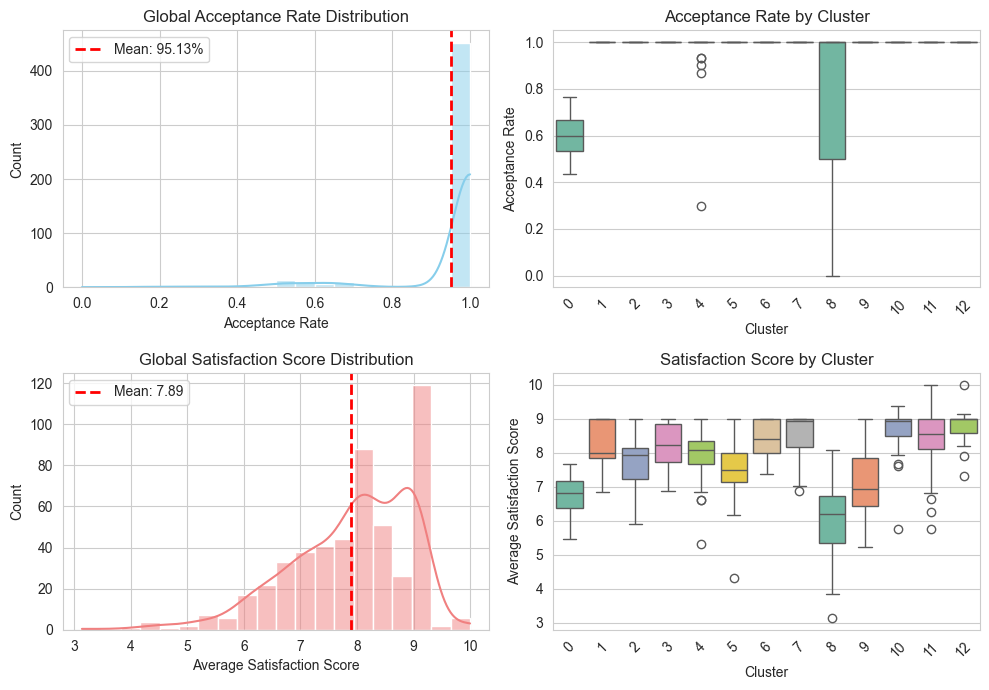

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

# 1. Global Acceptance Rate Distribution
ax1 = axes[0, 0]
sns.histplot(
    data=cluster_eval_df,
    x='acceptance_rate',
    bins=20,
    kde=True,
    color='skyblue',
    ax=ax1
)
ax1.axvline(
    cluster_eval_df['acceptance_rate'].mean(),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Mean: {cluster_eval_df['acceptance_rate'].mean():.2%}"
)
ax1.set_xlabel('Acceptance Rate')
ax1.set_ylabel('Count')
ax1.set_title('Global Acceptance Rate Distribution')
ax1.legend()

# 2. Acceptance Rate by Cluster
ax2 = axes[0, 1]
sns.boxplot(
    data=cluster_eval_df,
    x='cluster',
    y='acceptance_rate',
    palette='Set2',
    ax=ax2
)
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Acceptance Rate')
ax2.set_title('Acceptance Rate by Cluster')
ax2.tick_params(axis='x', rotation=45)

# 3. Global Satisfaction Score Distribution
ax3 = axes[1, 0]
sns.histplot(
    data=cluster_eval_df,
    x='avg_satisfaction',
    bins=20,
    kde=True,
    color='lightcoral',
    ax=ax3
)
ax3.axvline(
    cluster_eval_df['avg_satisfaction'].mean(),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Mean: {cluster_eval_df['avg_satisfaction'].mean():.2f}"
)
ax3.set_xlabel('Average Satisfaction Score')
ax3.set_ylabel('Count')
ax3.set_title('Global Satisfaction Score Distribution')
ax3.legend()

# 4. Satisfaction Score by Cluster
ax4 = axes[1, 1]
sns.boxplot(
    data=cluster_eval_df,
    x='cluster',
    y='avg_satisfaction',
    palette='Set2',
    ax=ax4
)
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Average Satisfaction Score')
ax4.set_title('Satisfaction Score by Cluster')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [4]:
baseline_summary, baseline_raw = run_random_baseline_pipeline(
    clustered_df=clustered_df,
    product_catalog=PRODUCT_CATALOG,
    api_key=API_KEY,
    n_iterations=10,
    sample_size_per_product=30,
    save_results=True,
    prefix="base_eval_5"
)

2026-01-06 18:16:05,645 - modules.evaluation.baseline_evaluation - INFO - Starting baseline evaluation: 13 products, 10 iterations, sample size 30
2026-01-06 18:16:05,646 - modules.evaluation.baseline_evaluation - INFO - Evaluating product: Apex Rewards Signature
2026-01-06 18:16:05,934 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:16:06,988 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:16:07,001 - modules.evaluation.baseline_evaluation - INFO - Product Apex_Rewards_Signature, iteration 1/10: Accept=100.00%, Satisfaction=6.97
2026-01-06 18:16:07,244 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:16:08,552 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:16:08,560 - modules.evaluation.baseline_evaluation - INFO - Product Apex_Rewards_Signature

❌ Cerebras Error: 'NoneType' object has no attribute 'strip'
Raw model output:
N/A


2026-01-06 18:16:33,992 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:16:35,555 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:16:35,561 - modules.evaluation.baseline_evaluation - INFO - Product Apex_Founders_Edition, iteration 2/10: Accept=40.00%, Satisfaction=6.60
2026-01-06 18:16:35,807 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:16:37,724 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:16:37,732 - modules.evaluation.baseline_evaluation - INFO - Product Apex_Founders_Edition, iteration 3/10: Accept=100.00%, Satisfaction=6.97
2026-01-06 18:16:38,013 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:16:40,083 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/complet

❌ Cerebras Error: 'NoneType' object has no attribute 'strip'
Raw model output:
N/A


2026-01-06 18:17:42,966 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:17:44,903 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:17:44,906 - modules.evaluation.baseline_evaluation - INFO - Product Apex_Founders_Edition, iteration 6/10: Accept=100.00%, Satisfaction=7.20
2026-01-06 18:17:45,208 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:17:47,668 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:17:47,676 - modules.evaluation.baseline_evaluation - INFO - Product Apex_Founders_Edition, iteration 7/10: Accept=100.00%, Satisfaction=7.50
2026-01-06 18:17:47,921 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:17:48,157 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/comple

❌ Cerebras Error: Error code: 429 - {'message': "We're experiencing high traffic right now! Please try again soon.", 'type': 'too_many_requests_error', 'param': 'queue', 'code': 'queue_exceeded'}
Raw model output:
N/A


2026-01-06 18:17:48,414 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:17:50,522 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:17:50,545 - modules.evaluation.baseline_evaluation - WARNING - Product Apex_Founders_Edition, iteration 9: No valid results


❌ Cerebras Error: 'NoneType' object has no attribute 'strip'
Raw model output:
N/A


2026-01-06 18:17:50,778 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:17:52,584 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:17:52,591 - modules.evaluation.baseline_evaluation - INFO - Product Apex_Founders_Edition, iteration 10/10: Accept=100.00%, Satisfaction=8.03
2026-01-06 18:17:52,593 - modules.evaluation.baseline_evaluation - INFO - Product Apex Founders Edition summary: Acceptance=90.00% (±24.49%), Satisfaction=7.08 (±0.65)
2026-01-06 18:17:52,594 - modules.evaluation.baseline_evaluation - INFO - Evaluating product: Unified Balance Loan
2026-01-06 18:17:52,875 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:17:54,733 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:17:54,740 - modules.evaluation.baseline_evaluation - WARNING - Product 

❌ Cerebras Error: Unterminated string starting at: line 1 column 261 (char 260)
Raw model output:
[{"decision":"rejected","satisfaction_score":4,"reason":"No existing loan, consolidation unnecessary."},{"decision":"accepted","satisfaction_score":9,"reason":"Consolidates debt, lowers monthly payment."},{"decision":"rejected","satisfaction_score":3,"reason":"No loan to consolidate, no added


2026-01-06 18:17:54,980 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:17:55,245 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2026-01-06 18:17:55,249 - modules.evaluation.baseline_evaluation - WARNING - Product Unified_Balance_Loan, iteration 2: No valid results


❌ Cerebras Error: Error code: 429 - {'message': "We're experiencing high traffic right now! Please try again soon.", 'type': 'too_many_requests_error', 'param': 'queue', 'code': 'queue_exceeded'}
Raw model output:
N/A


2026-01-06 18:17:55,527 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:17:56,987 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:17:56,993 - modules.evaluation.baseline_evaluation - INFO - Product Unified_Balance_Loan, iteration 3/10: Accept=43.33%, Satisfaction=5.17
2026-01-06 18:17:57,325 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:17:58,877 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:17:58,885 - modules.evaluation.baseline_evaluation - INFO - Product Unified_Balance_Loan, iteration 4/10: Accept=30.00%, Satisfaction=5.50
2026-01-06 18:17:59,168 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:18:01,493 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completion

❌ Cerebras Error: 'NoneType' object has no attribute 'strip'
Raw model output:
N/A


2026-01-06 18:19:04,426 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:19:06,272 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:19:06,279 - modules.evaluation.baseline_evaluation - INFO - Product Unified_Balance_Loan, iteration 7/10: Accept=40.00%, Satisfaction=5.00
2026-01-06 18:19:06,557 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:19:09,487 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:19:09,493 - modules.evaluation.baseline_evaluation - INFO - Product Unified_Balance_Loan, iteration 8/10: Accept=20.00%, Satisfaction=5.00
2026-01-06 18:19:09,742 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:19:11,022 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completion

❌ Cerebras Error: Error code: 429 - {'message': "We're experiencing high traffic right now! Please try again soon.", 'type': 'too_many_requests_error', 'param': 'queue', 'code': 'queue_exceeded'}
Raw model output:
N/A


2026-01-06 18:19:13,434 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:19:14,708 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:19:14,735 - modules.evaluation.baseline_evaluation - INFO - Product Relief_Plus_Consolidation, iteration 2/10: Accept=33.33%, Satisfaction=5.67
2026-01-06 18:19:14,968 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:19:17,371 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:19:17,379 - modules.evaluation.baseline_evaluation - INFO - Product Relief_Plus_Consolidation, iteration 3/10: Accept=40.00%, Satisfaction=6.00
2026-01-06 18:19:17,673 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:19:20,033 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/

❌ Cerebras Error: 'NoneType' object has no attribute 'strip'
Raw model output:
N/A


2026-01-06 18:21:01,314 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:21:03,471 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:21:03,477 - modules.evaluation.baseline_evaluation - INFO - Product FlexAccess_Line, iteration 10/10: Accept=100.00%, Satisfaction=7.00
2026-01-06 18:21:03,480 - modules.evaluation.baseline_evaluation - INFO - Product FlexAccess Line summary: Acceptance=80.00% (±21.73%), Satisfaction=6.44 (±0.73)
2026-01-06 18:21:03,482 - modules.evaluation.baseline_evaluation - INFO - Evaluating product: SafetyNet Starter
2026-01-06 18:21:03,722 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:21:04,907 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:21:04,912 - modules.evaluation.baseline_evaluation - INFO - Product SafetyNet_Starter,

❌ Cerebras Error: 'NoneType' object has no attribute 'strip'
Raw model output:
N/A


2026-01-06 18:22:31,975 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:22:32,337 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2026-01-06 18:22:32,339 - cerebras.cloud.sdk._base_client - INFO - Retrying request to /v1/chat/completions in 60.000000 seconds
2026-01-06 18:23:34,261 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:23:34,267 - modules.evaluation.baseline_evaluation - INFO - Product YieldMax_Account, iteration 5/10: Accept=96.67%, Satisfaction=8.37
2026-01-06 18:23:34,507 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:23:36,615 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:23:36,619 - modules.evaluation.baseline_evaluation - INFO - Product YieldMax_Account, iteration

❌ Cerebras Error: Unterminated string starting at: line 1 column 704 (char 703)
Raw model output:
[{"decision":"rejected","satisfaction_score":3,"reason":"No loan to offset, limited immediate benefit"},{"decision":"accepted","satisfaction_score":8,"reason":"Offsets loan interest using sizable savings"},{"decision":"rejected","satisfaction_score":3,"reason":"No loan, offset provides no current value"},{"decision":"accepted","satisfaction_score":9,"reason":"Large savings dramatically reduce loan interest"},{"decision":"rejected","satisfaction_score":3,"reason":"No loan to offset, limited benefit now"},{"decision":"rejected","satisfaction_score":2,"reason":"No loan, offset not applicable"},{"decision":"accepted","satisfaction_score":8,"reason":"Savings offset high loan interest effectively"},{"


2026-01-06 18:26:47,829 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:26:49,567 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:26:49,596 - modules.evaluation.baseline_evaluation - INFO - Product SmartLink_Offset, iteration 2/10: Accept=30.00%, Satisfaction=4.67
2026-01-06 18:26:49,833 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:26:51,000 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:26:51,006 - modules.evaluation.baseline_evaluation - INFO - Product SmartLink_Offset, iteration 3/10: Accept=40.00%, Satisfaction=4.80
2026-01-06 18:26:51,305 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:26:52,945 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/

❌ Cerebras Error: Expecting ',' delimiter: line 1 column 2646 (char 2645)
Raw model output:
[{"decision":"accepted","satisfaction_score":8,"reason":"Lower APR saves interest, deposit continues earning."},{"decision":"rejected","satisfaction_score":4,"reason":"No loan to secure, limited immediate benefit."},{"decision":"rejected","satisfaction_score":4,"reason":"No existing loan, rate drop not applicable."},{"decision":"rejected","satisfaction_score":4,"reason":"Without loan, product offers little immediate value."},{"decision":"accepted","satisfaction_score":8,"reason":"Secured rate cut reduces payments, savings still grow."},{"decision":"accepted","satisfaction_score":8,"reason":"Secured rate cut reduces payments, savings still grow."},{"decision":"rejected","satisfaction_score":4,"reason":"No loan to secure, limited benefit now."},{"decision":"rejected","satisfaction_score":4,"reason":"No loan present, rate reduction not usable now."},{"decision":"accepted","satisfaction_score":8,"re

2026-01-06 18:28:25,935 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:28:27,390 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:28:27,395 - modules.evaluation.baseline_evaluation - INFO - Product Secured_Rate_Smasher, iteration 7/10: Accept=53.33%, Satisfaction=6.17
2026-01-06 18:28:27,634 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:28:28,588 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 18:28:28,594 - modules.evaluation.baseline_evaluation - INFO - Product Secured_Rate_Smasher, iteration 8/10: Accept=20.69%, Satisfaction=5.03
2026-01-06 18:28:28,880 - httpx - INFO - HTTP Request: GET https://api.cerebras.ai/v1/tcp_warming "HTTP/1.1 200 OK"
2026-01-06 18:28:29,960 - httpx - INFO - HTTP Request: POST https://api.cerebras.ai/v1/chat/completion

In [5]:
import pandas as pd

files_and_offsets = [
    ("../data/1_agent_evaluation/base_eval_1_raw.parquet", 0),
    ("../data/1_agent_evaluation/base_eval_2_raw.parquet", 5),
    ("../data/1_agent_evaluation/base_eval_3_raw.parquet", 15),
    ("../data/1_agent_evaluation/base_eval_4_raw.parquet", 20),
    ("../data/1_agent_evaluation/base_eval_5_raw.parquet", 30),
]

dfs = []

for path, offset in files_and_offsets:
    df = pd.read_parquet(path)
    if offset:
        df["iteration"] = df["iteration"] + offset
    dfs.append(df)

base_eval_df = pd.concat(dfs, ignore_index=True)


/var/folders/8f/6znkn6r55qj5dgt5vxxlvwjm0000gn/T/ipykernel_61590/349981071.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/8f/6znkn6r55qj5dgt5vxxlvwjm0000gn/T/ipykernel_61590/349981071.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


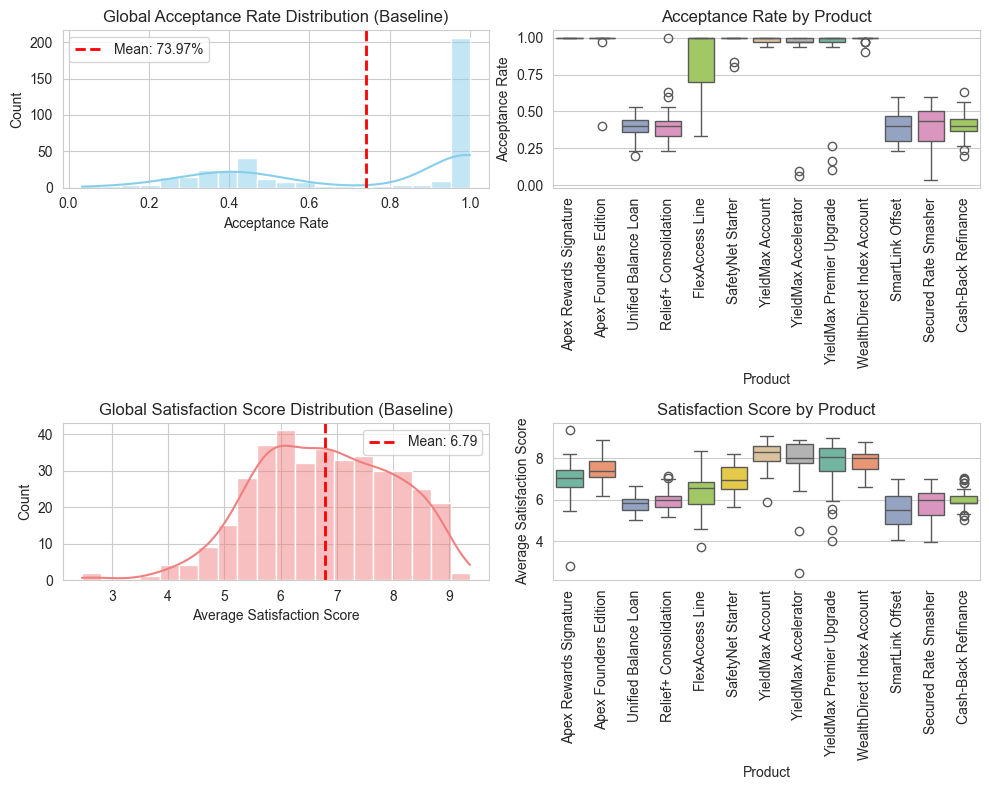

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# 1. Global Acceptance Rate Distribution
ax1 = axes[0, 0]
sns.histplot(
    data=base_eval_df,
    x='acceptance_rate',
    bins=20,
    kde=True,
    color='skyblue',
    ax=ax1
)
ax1.axvline(
    base_eval_df['acceptance_rate'].mean(),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Mean: {base_eval_df['acceptance_rate'].mean():.2%}"
)
ax1.set_xlabel('Acceptance Rate')
ax1.set_ylabel('Count')
ax1.set_title('Global Acceptance Rate Distribution (Baseline)')
ax1.legend()

# 2. Acceptance Rate by Product
ax2 = axes[0, 1]
sns.boxplot(
    data=base_eval_df,
    x='product_name',
    y='acceptance_rate',
    palette='Set2',
    ax=ax2
)
ax2.set_xlabel('Product')
ax2.set_ylabel('Acceptance Rate')
ax2.set_title('Acceptance Rate by Product')
ax2.tick_params(axis='x', rotation=90)

# 3. Global Satisfaction Score Distribution
ax3 = axes[1, 0]
sns.histplot(
    data=base_eval_df,
    x='avg_satisfaction',
    bins=20,
    kde=True,
    color='lightcoral',
    ax=ax3
)
ax3.axvline(
    base_eval_df['avg_satisfaction'].mean(),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Mean: {base_eval_df['avg_satisfaction'].mean():.2f}"
)
ax3.set_xlabel('Average Satisfaction Score')
ax3.set_ylabel('Count')
ax3.set_title('Global Satisfaction Score Distribution (Baseline)')
ax3.legend()

# 4. Satisfaction Score by Product
ax4 = axes[1, 1]
sns.boxplot(
    data=base_eval_df,
    x='product_name',
    y='avg_satisfaction',
    palette='Set2',
    ax=ax4
)
ax4.set_xlabel('Product')
ax4.set_ylabel('Average Satisfaction Score')
ax4.set_title('Satisfaction Score by Product')
ax4.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()